# Q-learning exploit&exploration and discounted reward


### Q-learning의 한계

- Exploit 만을 활용하는 문제
케이스에 따라(random하게 움직임을 선택) 성공률이 80%가까이 떨어지는 경우도 발생한다.  한번 발견한 길을 계속 유지하여 최단 거리로 갈수 있는 방법이 있지만 경험을 유지하는 알고리즘의 문제로 다른 더 좋은 방법을 찾지 못한다.

![ㅇ](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FsVvPR%2FbtrAssBiz21%2F79W6i9Lz47N9I8ofqrMVz1%2Fimg.png)

- 더 경로를 찾기 위한 방법을 찾는법 ->  Exploration 필요



In [49]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gym
from gym.envs.registration import register

In [50]:
#환경 변수
IDX_ACTION_UP = 0
IDX_ACTION_DOWN = 1
IDX_ACTION_RIGHT = 2
IDX_ACTION_LEFT = 3

STR_ACTION_UP = 'U'
STR_ACTION_DOWN = 'D'
STR_ACTION_RIGHT = 'R'
STR_ACTION_LEFT = 'L'

ENV_ID = 'FrozenLake-v3'
NUM_EPISODES = 2000

# 환경 등록
def get_env_register(env_id):
    env_dict = gym.envs.registry.env_specs.copy()
 
    for env in env_dict:
        if env_id in env:
            print('Remove {} from registry'.format(env))
            del gym.envs.registry.env_specs[env]   

    register(
        id=env_id,
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name': '4x4',
                'is_slippery': False}
    )
    
    env = gym.make(env_id)

    return env

# Q-table 시각화
def print_str_direct(q_value):
    cnt = 0
    while cnt < len(q_value):
        txt = ''
        for _ in range(4):
            # q-value가 실수인 경우 보완
            q = ''.join([str(int(round(e, 0))) for e in q_value[cnt]])
            if q == '1000':
                txt += STR_ACTION_UP
            elif q == '0100':
                txt += STR_ACTION_DOWN
            elif q == '0010':
                txt += STR_ACTION_RIGHT
            elif q == '0001':
                txt += STR_ACTION_LEFT
            else:
                txt += ' '
            txt += ' | '
            cnt += 1
        print(txt)    

def print_q_table(q_value):
    print('-'*50)
    print("Final Q-Table Values")
    print('-'*50)
    print('state | U   D   R   L')
    print(q_value)


### Exploit & Exploration
기존의 Q-leaning의 방법을 유지(Exploit)하면서도 다른 좋은 경로를 찾기위해 탐험(Exploration)을 시도할 수 있도록 알고리즘을 개선한 방법

1. Decaying E-greedy
2. Add random noise 
3. Discounted future reward



## Decaying E-greedy
- 학습초기에는 탐험을 많이하고 뒤로 갈수록 경험을 활용하도록 e 값을 줄여줌 
- e값(0.1)이라면 10%만큼 랜덤하게 탐험을 많이하다가 e값을 계속 decay시킴
 ```
 for i in range(1000)
   e = 0.1 /(i+1)
   if random(1)<e:
     a = random
   else:
     a = argmax(Q(s,a))
 ```

 
 

In [53]:
# Q-learning algorithm with Decaying E-greedy
def do_qlearning_decay_egreedy(env, num_episodes):
    q_value = np.zeros([env.observation_space.n, env.action_space.n])
    print('q_value shale:', q_value.shape)

    rList = []
    cntList = []   

    for i in range(num_episodes):
        state = env.reset() 
        rAll = 0 
        done = False
        action_cnt = 0

        # exploration의 확률 (decaying)
        e = 1./((i // 100) + 1)

        while not done:            
            # E-Greedy 알고리즘으로 action 고르기
            if np.random.uniform(0, 1) < e:
                action = env.action_space.sample()
            else : 
                action = np.argmax(q_value[state, :])

            new_state, reward, done, _ = env.step(action)
            
            q_value[state, action] = reward + np.max(q_value[new_state, :])
            
            rAll += reward
            action_cnt +=1
            state = new_state

        rList.append(rAll)
        cntList.append(action_cnt)

    return q_value, rList, cntList

Remove FrozenLake-v3 from registry
q_value shale: (16, 4)
[[1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [1. 0. 1. 1.]
 [1. 1. 1. 0.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]]
Success rate: 0.0045
Success average action : 108.9975


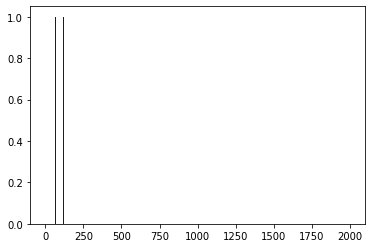

In [54]:
env = get_env_register(ENV_ID)

q_value, rList, cntList = do_qlearning_decay_egreedy(env, NUM_EPISODES)
print(q_value)

print("Success rate: " + str(sum(rList) / NUM_EPISODES))
print("Success average action : " + str(sum(cntList) / NUM_EPISODES)) # 평균 액션 횟수
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

### Q-value가 같은 값일때의 한계 
알고리즘에서 탐험을 반영하였지만 Exploit 정보와 Exploration 정보가 뒤섞여 agent가 판단을 잘 못하고있다. 

 - Q-value : Action을 하게될 때 받는 미래의 보상으로 더 좋은 선택하기에 정보가 부족하다.
 - 1번 길과 2번 길중 어느 길이 좋은지 판단할 수 없다.
 
![ㅇ](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdoLtpB%2FbtrAuMsgezH%2FtDO9b2jOptCnQgZua6uZ91%2Fimg.png)


## Discounted future reward

 - 보상은 유지하고, q-value은 감쇠인자(Discounted factor)를 곱해 줄여준다.

![ㅇ](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fd4DyR6%2FbtrAqsBCztT%2FyiOh1HkAch7sxrwuOkQJh1%2Fimg.png)


S10의 상태에서 어느 길이 좋은지 선택이 가능하다.

미래 보상이 더큰쪽으로 action down(주황색)을 행하면될것이다.

- ramma = 0.9일때 S10 state 일 때 action별 reward계산 
 - action down 일때 $R_t = 0 + 0.9*(1)$
 - action left 일때 $R_t = 0 + 0.9*(0+0.9*(0+0.9) = 0.729$


![ㅇ](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FegTvTy%2FbtrAp5NVoq8%2Fm9OHit1MeIYz6Z6XMkjmI0%2Fimg.png)



In [56]:
# Q-learning algorithm with Decaying E-greedy
def do_qlearning_decay_egreedy(env, num_episodes):
    q_value = np.zeros([env.observation_space.n, env.action_space.n])
    print('q_value shale:', q_value.shape)

    rList = []
    cntList = []   

    dis = 0.99

    for i in range(num_episodes):
        state = env.reset() 
        rAll = 0 
        done = False
        action_cnt = 0

        # exploration의 확률 (decaying)
        e = 1./((i // 100) + 1)

        while not done:            
            # E-Greedy 알고리즘으로 action 고르기
            if np.random.uniform(0, 1) < e:
                action = env.action_space.sample()
            else : 
                action = np.argmax(q_value[state, :])

            new_state, reward, done, _ = env.step(action)
            
            q_value[state, action] = reward + dis * np.max(q_value[new_state, :])
            
            rAll += reward
            action_cnt +=1
            state = new_state

        rList.append(rAll)
        cntList.append(action_cnt)

    return q_value, rList, cntList

Remove FrozenLake-v3 from registry
q_value shale: (16, 4)
[[0.94148015 0.95099005 0.95099005 0.94148015]
 [0.94148015 0.         0.96059601 0.95099005]
 [0.95099005 0.970299   0.91351725 0.96059601]
 [0.92274469 0.         0.         0.91351725]
 [0.95099005 0.96059601 0.         0.94148015]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.         0.96059601]
 [0.         0.         0.         0.        ]
 [0.96059601 0.         0.970299   0.95099005]
 [0.96059601 0.9801     0.9801     0.        ]
 [0.970299   0.99       0.         0.970299  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.99       0.970299  ]
 [0.9801     0.99       1.         0.9801    ]
 [0.         0.         0.         0.        ]]
Success rate: 0.8245
Success average action : 6.432


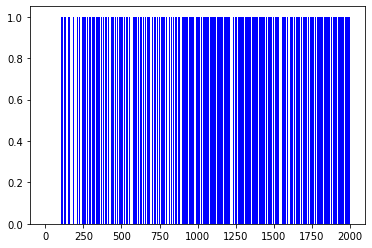

In [57]:
env = get_env_register(ENV_ID)

q_value, rList, cntList = do_qlearning_decay_egreedy(env, NUM_EPISODES)
print(q_value)

print("Success rate: " + str(sum(rList) / NUM_EPISODES))
print("Success average action : " + str(sum(cntList) / NUM_EPISODES)) # 평균 액션 횟수
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

discounted factor를 적용하였지만 e-Greedy는 기존 q-value(학습데이터)에 근거하지 않고 랜덤으로만 진행한 횟수가 많아서 성공 확률이 떨어진다. 탐험도 하면서 기존에 경험도 반영하여 시행착오를 좀 줄 일 수 있게 개선한 방식이 **Add random noise**방식이다.

- cf. route출력
> Exploration을 진행하여 q-value의 확률이 4가지 action에 고르게 분포하게되어 최적경로를 나타내지 못하였다. 이부분은 보완이 필요하겠다.

In [58]:
#최종 route 출력
print_str_direct(q_value)

  |   |   |   | 
  |   |   |   | 
  |   |   |   | 
  |   |   |   | 


## Add random noise
- 고정적인 Q value에 random값을 더하여 경험하도록한다.
- Decaying E-greedy 방식보다 경험에 의거하여 랜덤한 활동을 하게한다. 즉, 탐험시 경험도 활용하게 하여 효율을 높인다. 
- 역시 경험횟수가 늘수록 탐험율을 줄임.
 ```
 for i in range(1000)
   a = argmax(Q(s,a) + random_value/(i+1))
 ```

In [61]:
# Q-learning algorithm with random noise
def do_qlearning_add_noise(env, num_episodes):
    q_value = np.zeros([env.observation_space.n, env.action_space.n])
    print('q_value shale:', q_value.shape)

    rList = []
    cntList = []   

    dis = 0.99

    for i in range(num_episodes):
        state = env.reset() 
        rAll = 0 
        done = False
        action_cnt = 0

        # exploration의 확률 (decaying)
        e = 1./((i // 100) + 1)

        while not done:            
            action = np.argmax(q_value[state, :] + np.random.randn(1, env.action_space.n) / (i+1)) 

            new_state, reward, done, _ = env.step(action)
            
            q_value[state, action] = reward + dis * np.max(q_value[new_state, :])
            
            rAll += reward
            action_cnt +=1
            state = new_state

        rList.append(rAll)
        cntList.append(action_cnt)

    return q_value, rList, cntList

Remove FrozenLake-v3 from registry
q_value shale: (16, 4)
Success rate: 0.975
Success average action : 6.0385


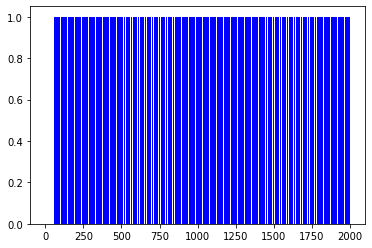

In [62]:
env = get_env_register(ENV_ID)
q_value, rList, cntList = do_qlearning_add_noise(env, NUM_EPISODES)

print("Success rate: " + str(sum(rList) / NUM_EPISODES))
print("Success average action : " + str(sum(cntList) / NUM_EPISODES)) # 평균 액션 횟수
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

In [ ]:
#최종 route 출력
print_str_direct(q_value)

D |   |   |   | 
D |   |   |   | 
R | D |   |   | 
  | R | R |   | 


Remove FrozenLake-v3 from registry
Success rate: 0.9365
Success average action : 6.0985


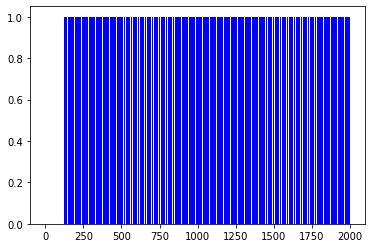

In [ ]:
env = get_env_register(ENV_ID)
q_value, rList, cntList = do_qlearning_add_noise(env, NUM_EPISODES)

print("Success rate: " + str(sum(rList) / NUM_EPISODES))
print("Success average action : " + str(sum(cntList) / NUM_EPISODES)) # 평균 액션 횟수
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

In [ ]:
#최종 route 출력
print_str_direct(q_value)

D |   | D |   | 
D |   | D |   | 
R | D | D |   | 
  | R | R |   | 


In [ ]:
q_value

array([[0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]])

In [ ]:
# Q-learning algorithm with discounted future reward
def do_qlearning_discounted_reward(env, num_episodes):
    
    # Q Table을 모두 0으로 초기화 한다. : 2차원 (number of state, action space) = (16,4)
    Q = np.zeros([env.observation_space.n, env.action_space.n])

    # discount 정의 => 미래의 reward를 현재의 reward 보다 조금 낮게 본다.
    dis = 0.99

    # 몇 번 시도를 할 것인가 (에피소드)
    num_episodes = 2000

    # 에피소드마다 총 리워드의 합을 저장하는 리스트
    rList = []
    cntList = [] 

    for i in range(num_episodes) : 
        state = env.reset()
        rAll = 0
        done = False
        action_cnt = 0
        
        while not done :            
            action = np.argmax(Q[state, :] + np.random.randn(1, env.action_space.n) / (i+1)) 
            
            # 해당 Action을 했을 때 environment가 변하고, 새로운 state, reward, done 여부를 반환 받음
            new_state, reward, done, _ = env.step(action)
            
            # Q = R + Q 
            Q[state, action] = reward + dis * np.max(Q[new_state, :])
            
            rAll += reward
            action_cnt +=1
            state = new_state
            
        rList.append(rAll)
        cntList.append(action_cnt)

    return Q, rList, cntList

Remove FrozenLake-v3 from registry
Success rate: 0.9045
Success average action : 6.156
D |   |   |   | 
D |   |   |   | 
R | D |   |   | 
  | R | R |   | 


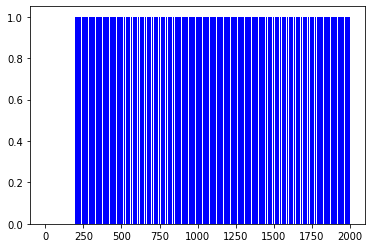

In [ ]:
env = get_env_register(ENV_ID)
q_value, rList, cntList = do_qlearning_discounted_reward(env, NUM_EPISODES)

print("Success rate: " + str(sum(rList) / NUM_EPISODES))
print("Success average action : " + str(sum(cntList) / NUM_EPISODES)) # 평균 액션 횟수

#최종 route 출력
print_str_direct(q_value)
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

Remove FrozenLake-v3 from registry
Success rate: 0.921
Success average action : 6.0865
R | R | D |   | 
  |   | D |   | 
  |   | D |   | 
  |   | R |   | 


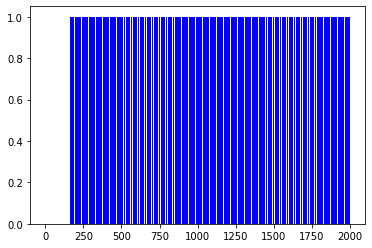

In [ ]:
env = get_env_register(ENV_ID)
q_value, rList, cntList = do_qlearning_discounted_reward(env, NUM_EPISODES)

print("Success rate: " + str(sum(rList) / NUM_EPISODES))
print("Success average action : " + str(sum(cntList) / NUM_EPISODES)) # 평균 액션 횟수

#최종 route 출력
print_str_direct(q_value)
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

Remove FrozenLake-v3 from registry
Success rate: 0.972
Success average action : 6.06
R | R | D |   | 
  |   | D |   | 
  |   | D |   | 
  |   | R |   | 


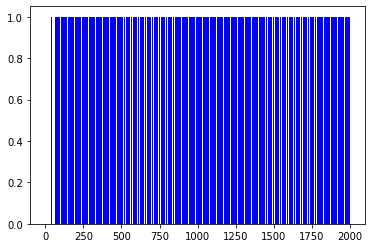

In [ ]:
env = get_env_register(ENV_ID)
q_value, rList, cntList = do_qlearning_discounted_reward(env, NUM_EPISODES)

print("Success rate: " + str(sum(rList) / NUM_EPISODES))
print("Success average action : " + str(sum(cntList) / NUM_EPISODES)) # 평균 액션 횟수

#최종 route 출력
print_str_direct(q_value)
plt.bar(range(len(rList)), rList, color="blue")
plt.show()